### Resample from the 2012-2020 data, does gridsearch using new metric

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix,plot_roc_curve, roc_curve, precision_score,roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.metrics import make_scorer, recall_score
# Create a specificity scorer
specificity_scorer = make_scorer(recall_score, pos_label=0)

df = pd.read_csv('climate_frog1220_7vars.csv').dropna()
X = df[['aet_mean','pet_mean', 'ppt_mean', 'srad_mean', 'tmax_mean', 'tmin_mean','vap_mean']]
y = df['occurrenceStatus']

In [42]:
df.shape

(49822, 20)

In [46]:
#This df still doesn't have any data for region5, and no Absence data for region4
# Test Region 1
df1 = df[(df['decimalLatitude']>=-38.5) & (df['decimalLatitude']<= -37.5) 
   & (df['decimalLongitude']>=144.8) & (df['decimalLongitude']<= 145.8) ].assign(region = 1)
# Test Region 2
df2 = df[(df['decimalLatitude']>=-33.5) & (df['decimalLatitude']<= -32.5) 
   & (df['decimalLongitude']>=150.7) & (df['decimalLongitude']<= 151.7) ].assign(region = 2)
# Test Region 3
df3 = df[(df['decimalLatitude']>=-29) & (df['decimalLatitude']<= -28) 
   & (df['decimalLongitude']>=152.6) & (df['decimalLongitude']<= 153.6) ].assign(region = 3)
# Test Region 4
df4 = df[(df['decimalLatitude']>=-17.7) & (df['decimalLatitude']<= -16.7) 
   & (df['decimalLongitude']>=145) & (df['decimalLongitude']<= 146) ].assign(region = 4)
# Test Region 5
df5 = df[(df['decimalLongitude']<= 116.7) & (df['decimalLongitude']>=115.7) 
    & (df['decimalLatitude']<= -31.5) & (df['decimalLatitude']>=-32.5)].assign(region = 5)

<AxesSubplot:xlabel='region', ylabel='srad_mean'>

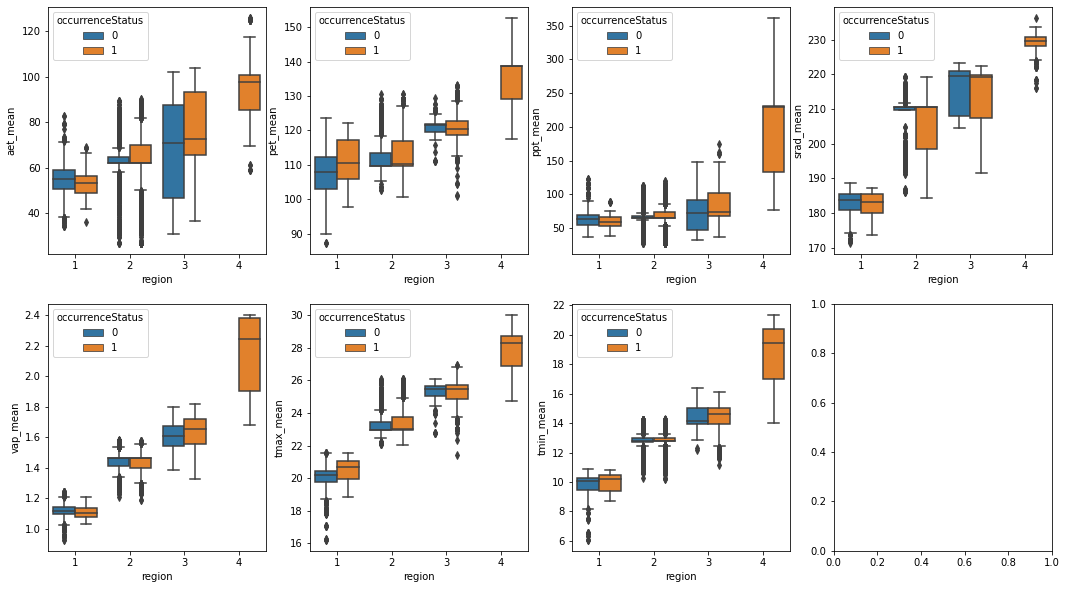

In [47]:
train5Regions = pd.concat([df1,df2,df3,df4,df5])
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
sns.boxplot(ax = axes[0,0], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'aet_mean')
sns.boxplot(ax = axes[0,1], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'pet_mean')
sns.boxplot(ax = axes[0,2], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'ppt_mean')
sns.boxplot(ax = axes[1,0], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'vap_mean')
sns.boxplot(ax = axes[1,1], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'tmax_mean')
sns.boxplot(ax = axes[1,2], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'tmin_mean')
sns.boxplot(ax = axes[0,3], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'srad_mean')

#### Just do a grid regardless

In [2]:
# do a train test split to reserve some data for testing. This k-fold will NOT use standardize
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.33, random_state=42)

In [49]:
params = {'max_depth':[3,4,5], 'min_samples_leaf': [20,30,40,50],'max_samples':[500,1500,2500],
         'n_estimators':[100,250,500],'criterion':['gini','entropy']}
scorings = {'f1':'f1','specificity':specificity_scorer,'roc_auc':'roc_auc','precision':'precision'}
clf = GridSearchCV(estimator = RandomForestClassifier(random_state = 0), param_grid = params, 
                   cv = 3, scoring = scorings, refit = 'specificity')
clf.fit(X_train,y_train)
print("The Best Model is : ", clf.best_estimator_)

The Best Model is :  RandomForestClassifier(max_depth=5, max_samples=1500, min_samples_leaf=20,
                       n_estimators=500, random_state=0)


In [51]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_max_samples', 'param_min_samples_leaf', 'param_n_estimators', 'params', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_specificity', 'split1_test_specificity', 'split2_test_specificity', 'mean_test_specificity', 'std_test_specificity', 'rank_test_specificity', 'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision'])

f1:  0.804935238945958 accuracy:  0.78749543851113


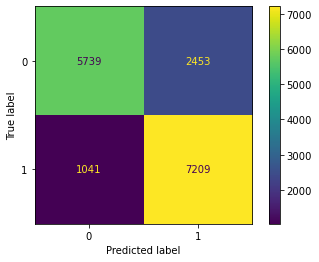

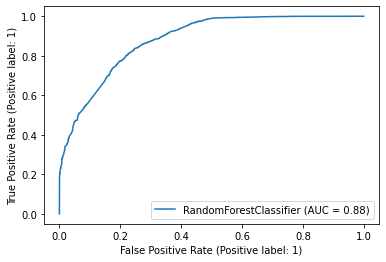

In [58]:
bestForest1 = clf.best_estimator_
y_pred = bestForest1.fit(X_train,y_train).predict(X_validation)
print('f1: ', f1_score(y_validation, y_pred),'accuracy: ',accuracy_score(y_validation, y_pred) )
disp= ConfusionMatrixDisplay(confusion_matrix(y_validation,y_pred))
disp.plot()
plot_roc_curve(bestForest1,X_validation,y_validation)

In [59]:
# follow-up grid search
params = {'max_depth':[3,4,5], 'min_samples_leaf': [20,22,25],'max_samples':[1000,1500,2000],
         'n_estimators':[400,500,600],'criterion':['gini','entropy']}
scorings = {'f1':'f1','specificity':specificity_scorer,'roc_auc':'roc_auc','precision':'precision'}
clf = GridSearchCV(estimator = RandomForestClassifier(random_state = 0), param_grid = params, 
                   cv = 3, scoring = scorings, refit = 'specificity', verbose = 3)
clf.fit(X_train,y_train)
print("The Best Model is : ", clf.best_estimator_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV 1/3] END criterion=gini, max_depth=3, max_samples=1000, min_samples_leaf=20, n_estimators=400; f1: (test=0.793) precision: (test=0.706) roc_auc: (test=0.862) specificity: (test=0.625) total time=   2.4s
[CV 2/3] END criterion=gini, max_depth=3, max_samples=1000, min_samples_leaf=20, n_estimators=400; f1: (test=0.790) precision: (test=0.711) roc_auc: (test=0.862) specificity: (test=0.640) total time=   2.0s
[CV 3/3] END criterion=gini, max_depth=3, max_samples=1000, min_samples_leaf=20, n_estimators=400; f1: (test=0.792) precision: (test=0.712) roc_auc: (test=0.863) specificity: (test=0.642) total time=   2.6s
[CV 1/3] END criterion=gini, max_depth=3, max_samples=1000, min_samples_leaf=20, n_estimators=500; f1: (test=0.793) precision: (test=0.706) roc_auc: (test=0.863) specificity: (test=0.624) total time=   3.0s
[CV 2/3] END criterion=gini, max_depth=3, max_samples=1000, min_samples_leaf=20, n_estimators=500; f1: (test=

f1:  0.8043526785714286 accuracy:  0.7867656002919353


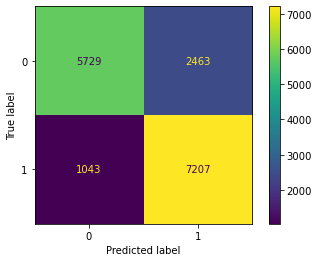

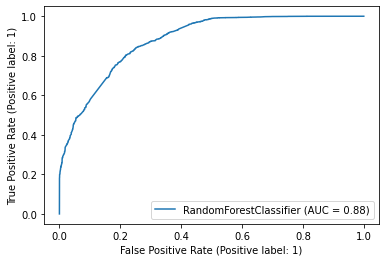

In [60]:
bestForest2 = clf.best_estimator_
y_pred = bestForest2.fit(X_train,y_train).predict(X_validation)
print('f1: ', f1_score(y_validation, y_pred),'accuracy: ',accuracy_score(y_validation, y_pred) )
disp= ConfusionMatrixDisplay(confusion_matrix(y_validation,y_pred))
disp.plot()
plot_roc_curve(bestForest2,X_validation,y_validation)

#### See graph to test submissions

In [3]:
# Based on GridSearch, our model would be: 
bestForest = RandomForestClassifier(random_state = 0, max_depth = 5, min_samples_leaf = 25, max_samples = 1500, 
                                    n_estimators = 400).fit(X,y)

In [5]:
w1 = xr.open_dataarray('weather_data_testRegion1.nc')
w2 = xr.open_dataarray('weather_data_testRegion2.nc')
w3 = xr.open_dataarray('weather_data_testRegion3.nc')
w4 = xr.open_dataarray('weather_data_testRegion4.nc')
w5 = xr.open_dataarray('weather_data_testRegion5.nc')
weather_lst = [w1,w2,w3,w4,w5]

In [6]:
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv('occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

In [7]:
min_lon1, min_lat1 = (144.8, -38.5)  # Lower-left corner
max_lon1, max_lat1 = (145.8, -37.5)  # Upper-right corner
bbox1 = (min_lon1, min_lat1, max_lon1, max_lat1)

min_lon2, min_lat2 = (150.7, -33.5)  # Lower-left corner
max_lon2, max_lat2 = (151.7, -32.5)  # Upper-right corner
bbox2 = (min_lon2, min_lat2, max_lon2, max_lat2)

min_lon3, min_lat3 = (152.6, -29.0)  # Lower-left corner
max_lon3, max_lat3 = (153.6, -28.0)  # Upper-right corner
bbox3 = (min_lon3, min_lat3, max_lon3, max_lat3)

min_lon4, min_lat4 = (145.0, -17.7)  # Lower-left corner
max_lon4, max_lat4 = (146.0, -16.7)  # Upper-right corner
bbox4 = (min_lon4, min_lat4, max_lon4, max_lat4)

min_lon5, min_lat5 = (115.7, -32.5)  # Lower-left corner
max_lon5, max_lat5 = (116.7, -31.5)  # Upper-right corner
bbox5 = (min_lon5, min_lat5, max_lon5, max_lat5)

# Load in data
boxes = [bbox1,bbox2,bbox3,bbox4,bbox5]

In [8]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    # predictor_image = predictor_image.sel(band=model.get_booster().feature_names)
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

In [10]:
# Load in test coordinates
test_file = pd.read_csv('challenge_1_submission_template.csv')

# Read in test regions
test_regions = []
with open('challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_regions.append(eval("("+line+")"))

# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_regions)]

In [11]:
test_regions

[{'title': 0, 'bbox': (144.8, -38.5, 145.8, -37.5)},
 {'title': 1, 'bbox': (150.7, -33.5, 151.7, -32.5)},
 {'title': 2, 'bbox': (152.6, -29.0, 153.6, -28.0)},
 {'title': 3, 'bbox': (145.0, -17.7, 146.0, -16.7)},
 {'title': 4, 'bbox': (115.7, -32.5, 116.7, -31.5)}]

In [16]:
for region in test_regions:
    print(type(region['title']))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


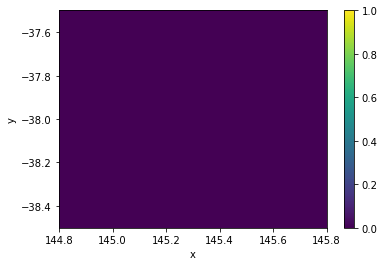

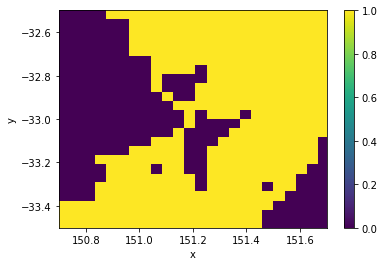

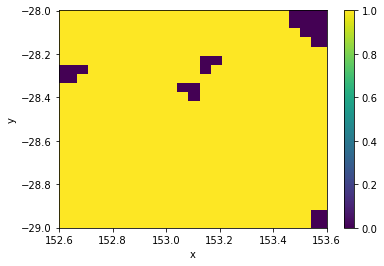

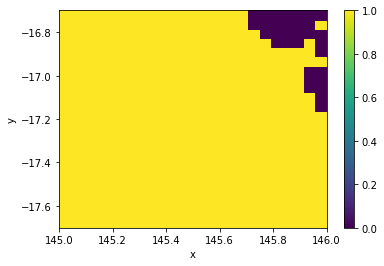

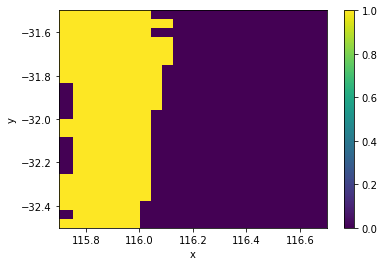

In [18]:
# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = weather_lst[region['title']]
    #get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    region['result'] = predict_frogs(region['predictors'], bestForest) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()

In [27]:
# Try the submission process with manually turning the last region into 0
predictions = pd.DataFrame()
for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)
submission.groupby('occurrenceStatus').count()

,id,decimalLatitude,decimalLongitude
occurrenceStatus,,,
0,1618,1618,1618
1,2433,2433,2433


In [28]:
submission[(submission['decimalLongitude'] < 116.7) & (submission['decimalLongitude'] > 115.7)].groupby('occurrenceStatus').count()

,id,decimalLatitude,decimalLongitude
occurrenceStatus,,,
0,86,86,86
1,512,512,512


In [77]:
submission.apply(lambda x:  0 ) # if x['decimalLongitude'] <= 116.7)

SyntaxError: invalid syntax (607215481.py, line 1)

In [22]:
submission.groupby('occurrenceStatus').count()

,id,decimalLatitude,decimalLongitude
occurrenceStatus,,,
0,1618,1618,1618
1,2433,2433,2433


In [80]:
submission.to_csv('w10_tue_grid.csv')

In [64]:
temp = submission[(submission['decimalLongitude'] < 116.7) & (submission['decimalLongitude'] > 115.7)]
temp.occurrenceStatus = 0
df = submission.merge(temp, right_on='id', left_on='id')

In [69]:
df

,id,decimalLatitude_x,decimalLongitude_x,occurrenceStatus_x,decimalLatitude_y,decimalLongitude_y,occurrenceStatus_y
0,3453,-31.936399,115.885910,1,-31.936399,115.885910,0
1,3454,-31.936399,115.887867,1,-31.936399,115.887867,0
2,3455,-31.938356,115.885910,1,-31.938356,115.885910,0
3,3456,-31.940313,115.883953,1,-31.940313,115.883953,0
4,3457,-32.045988,115.858513,1,-32.045988,115.858513,0
...,...,...,...,...,...,...,...
593,4046,-31.883562,116.150098,0,-31.883562,116.150098,0
594,4047,-32.413894,115.780235,1,-32.413894,115.780235,0
595,4048,-32.147750,115.856556,1,-32.147750,115.856556,0
596,4049,-31.826810,116.238160,0,-31.826810,116.238160,0


In [57]:
submission[(submission['decimalLongitude'] < 116.7) & (submission['decimalLongitude'] > 115.7)].loc[:, 'occurrenceStatus'] = 0

In [58]:
submission.groupby('occurrenceStatus').count()

,id,decimalLatitude,decimalLongitude
occurrenceStatus,,,
0,1618,1618,1618
1,2433,2433,2433


In [78]:
(submission[(submission['decimalLongitude'] < 116.7) & (submission['decimalLongitude'] > 115.7)].loc[:, 'occurrenceStatus'])

3453    1
3454    1
3455    1
3456    1
3457    1
       ..
4046    0
4047    1
4048    1
4049    0
4050    1
Name: occurrenceStatus, Length: 598, dtype: int32

In [79]:
[0 for i in range(598)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
